In [7]:
import numpy as np 
import pandas as pd
import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras import regularizers



In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "xray_dataset_covid19/train",
    validation_split=0.2,        
    subset="training",         
    seed=123,                    
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "xray_dataset_covid19/train",
    validation_split=0.2,
    subset="validation",         
    seed=123,
    image_size=(224, 224),
    batch_size=32
)


for images, labels in train_ds.take(1):
    print("Batch shape:", images.shape)      
    print("First image shape:", images[0].shape)  

Found 148 files belonging to 2 classes.
Using 119 files for training.
Found 148 files belonging to 2 classes.
Using 29 files for validation.
Batch shape: (32, 224, 224, 3)
First image shape: (224, 224, 3)


In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

l2_lambda = 0.001
model = tf.keras.Sequential([
    data_augmentation, 
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                  kernel_regularizer=regularizers.l2(l2_lambda),
                  input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(l2_lambda)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(l2_lambda)),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  
])



model.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=['accuracy']    
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history=history = model.fit(
    train_ds,
    validation_data=val_ds,  
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20


/Users/ritijraj/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 0.5534 - loss: 777.4587 - val_accuracy: 0.5862 - val_loss: 238.7855
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step - accuracy: 0.5187 - loss: 191.3006 - val_accuracy: 0.4138 - val_loss: 41.3433
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.4856 - loss: 23.0240 - val_accuracy: 0.5862 - val_loss: 1.9436
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.4583 - loss: 1.6719 - val_accuracy: 0.4483 - val_loss: 1.0671
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.5906 - loss: 1.0615 - val_accuracy: 0.7241 - val_loss: 0.9985
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.6635 - loss: 1.0229 - val_accuracy: 0.6897 - val_loss: 0.9652
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step - accuracy: 0.7061 - loss: 1.0137 - val_accuracy: 0.3793 - val_loss: 1.1469
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.7036 - loss: 0.9775 - val_accuracy: 0.8966 - val_loss: 0.

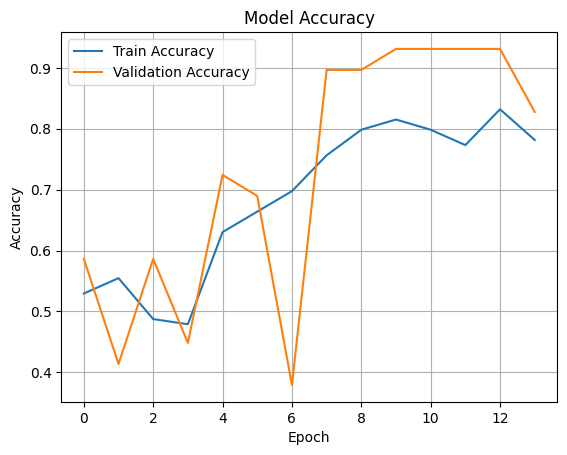

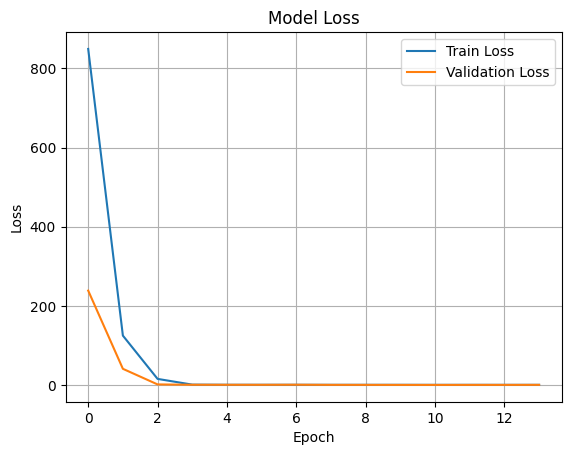

In [10]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
loss, accuracy = model.evaluate(val_ds)  
print(f"Accuracy: {accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9310 - loss: 0.6707
Accuracy: 0.9310


In [12]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "xray_dataset_covid19/test",
    image_size=(224,224),
    batch_size=32,
    shuffle=False
    
)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


y_pred = model.predict(test_ds)
y_pred_labels = (y_pred > 0.5).astype("int32")


y_true = np.concatenate([labels.numpy() for _, labels in test_ds], axis=0)


acc = accuracy_score(y_true, y_pred_labels)
print(f"Accuracy Score: {acc:.4f}")


print(classification_report(y_true, y_pred_labels, target_names=["Normal", "Pneumonia"]))


cm = confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:")
print(cm)



Found 40 files belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 
Accuracy Score: 1.0000
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        20
   Pneumonia       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion Matrix:
[[20  0]
 [ 0 20]]


2025-07-11 12:14:35.016426: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
